In [1]:
%load_ext autoreload
%autoreload 2
from scvi.dataset import (
    smfish,
    cortex,
)
from scvi.models import JVAE, Classifier
from scvi.inference import JVAETrainer
from scvi.dataset import setup_anndata

from scipy.stats import spearmanr
import scanpy

In [2]:
def imputation_score(trainer_both, data_spatial, gene_ids_test, normalized=True):
    _, fish_imputation = trainer_both.get_imputed_values(normalized=normalized)
    original, imputed = (
        data_spatial.X[:, gene_ids_test],
        fish_imputation[:, gene_ids_test],
    )

    if normalized:
        original /= data_spatial.X.sum(axis=1).reshape(-1, 1)

    spearman_gene = []
    for g in range(imputed.shape[1]):
        if np.all(imputed[:, g] == 0):
            correlation = 0
        else:
            correlation = spearmanr(original[:, g], imputed[:, g])[0]
        spearman_gene.append(correlation)
    return np.median(np.array(spearman_gene))


In [3]:
import numpy as np
import copy

In [8]:
test_mode = True

save_path = "../../data"

data_spatial = smfish(save_path=save_path, use_high_level_cluster = False)
# data_seq = cortex(
#     save_path=save_path
# )
scanpy.pp.filter_cells(data_spatial, min_counts= 1)
scanpy.pp.filter_cells(data_seq, min_counts = 1)


[2020-07-09 17:15:33,892] INFO - scvi.dataset._utils | File /Users/galen/data/osmFISH_SScortex_mouse_all_cell.loom already downloaded
[2020-07-09 17:15:33,894] INFO - scvi.dataset.smfish | Loading smFISH dataset


In [9]:
data_spatial.obs_names


Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '6461', '6462', '6463', '6464', '6465', '6466', '6467', '6468', '6469',
       '6470'],
      dtype='object', length=6430)

In [ ]:
data_spatial

In [67]:
np.where(len(np.sum(data_spatial.X, axis = 1))==0)

(array([], dtype=int64),)

In [60]:
data_seq

AnnData object with n_obs × n_vars = 3005 × 19972
    obs: 'labels', 'precise_labels', 'cell_type', '_scvi_batch', '_scvi_local_l_mean', '_scvi_local_l_var', 'n_counts'
    uns: 'scvi_data_registry', 'scvi_summary_stats'

In [66]:
np.where(len(np.sum(data_seq.X, axis = 1))==0)

(array([], dtype=int64),)

In [4]:
spatial_gene_names = data_spatial.var_names
data_seq = data_seq[:, spatial_gene_names].copy()
setup_anndata(data_seq, labels_key = 'labels')

[2020-07-08 22:26:56,365] INFO - scvi.dataset._anndata | Using data from adata.X
[2020-07-08 22:26:56,366] INFO - scvi.dataset._anndata | No batch_key inputted, assuming all cells are same batch
[2020-07-08 22:26:56,368] INFO - scvi.dataset._anndata | Using labels from adata.obs["labels"]
[2020-07-08 22:26:56,369] INFO - scvi.dataset._anndata | Computing library size prior per batch
[2020-07-08 22:26:56,372] WARNING - scvi.dataset._utils | This dataset has some empty cells, this might fail scVI inference.Data should be filtered with `my_dataset.filter_cells_by_count()
[2020-07-08 22:26:56,373] INFO - scvi.dataset._anndata | Successfully registered anndata object containing 3005 cells, 33 genes, and 1 batches 
Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']


In [5]:
data_seq

AnnData object with n_obs × n_vars = 3005 × 33
    obs: 'labels', 'precise_labels', 'cell_type', '_scvi_batch', '_scvi_local_l_mean', '_scvi_local_l_var'
    uns: 'scvi_data_registry', 'scvi_summary_stats'

In [6]:
data_seq.uns['scvi_summary_stats']

{'n_batch': 1, 'n_cells': 3005, 'n_genes': 33, 'n_labels': 7}

In [7]:
train_size = 0.8

gene_names_rnaseq = data_seq.var_names

np.random.seed(0)
n_genes = len(gene_names_rnaseq)
print(n_genes)
gene_ids_train = sorted(
    np.random.choice(range(n_genes), int(n_genes * train_size), False)
)
gene_ids_test = sorted(set(range(n_genes)) - set(gene_ids_train))

gene_names_fish = gene_names_rnaseq[gene_ids_train]
print(len(gene_names_fish))
# Create copy of the fish dataset with hidden genes
data_spatial_partial = data_spatial.copy()
data_spatial_partial= data_spatial_partial[:, gene_names_fish]

# data_spatial_partial.batch_indices += data_seq.uns['scvi_summary_stats']['n_batch']
data_spatial_partial.obs['_scvi_batch'] += data_seq.uns['scvi_summary_stats']['n_batch']

Trying to set attribute `.obs` of view, copying.


33
26


In [8]:
setup_anndata(data_spatial_partial, batch_key = '_scvi_batch')

[2020-07-08 22:26:56,511] INFO - scvi.dataset._anndata | Using data from adata.X
[2020-07-08 22:26:56,512] INFO - scvi.dataset._anndata | Using batches from adata.obs["_scvi_batch"]
[2020-07-08 22:26:56,513] INFO - scvi.dataset._anndata | No label_key inputted, assuming all cells have same label
[2020-07-08 22:26:56,515] INFO - scvi.dataset._anndata | Computing library size prior per batch
[2020-07-08 22:26:56,518] WARNING - scvi.dataset._utils | This dataset has some empty cells, this might fail scVI inference.Data should be filtered with `my_dataset.filter_cells_by_count()
[2020-07-08 22:26:56,520] INFO - scvi.dataset._anndata | Successfully registered anndata object containing 6471 cells, 26 genes, and 1 batches 
Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']


In [9]:
datasets = [data_seq, data_spatial_partial]
generative_distributions = ["zinb", "nb"]
gene_mappings = [slice(None), np.array(gene_ids_train)]
n_inputs = [d.uns['scvi_summary_stats']['n_genes'] for d in datasets]
total_genes = data_seq.uns['scvi_summary_stats']['n_genes']
n_batches = sum([d.uns['scvi_summary_stats']['n_batch'] for d in datasets])

model_library_size = [True, False]

n_latent = 8
kappa = 1

In [10]:
datasets

[AnnData object with n_obs × n_vars = 3005 × 33
     obs: 'labels', 'precise_labels', 'cell_type', '_scvi_batch', '_scvi_local_l_mean', '_scvi_local_l_var'
     uns: 'scvi_data_registry', 'scvi_summary_stats',
 AnnData object with n_obs × n_vars = 6471 × 26
     obs: 'x_coord', 'y_coord', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var'
     uns: 'cell_types', 'scvi_data_registry', 'scvi_summary_stats']

In [11]:
import torch

torch.manual_seed(0)

model = JVAE(
    n_inputs,
    total_genes,
    gene_mappings,
    generative_distributions,
    model_library_size,
    n_layers_decoder_individual=0,
    n_layers_decoder_shared=0,
    n_layers_encoder_individual=1,
    n_layers_encoder_shared=1,
    dim_hidden_encoder=64,
    dim_hidden_decoder_shared=64,
    dropout_rate_encoder=0.2,
    dropout_rate_decoder=0.2,
    n_batch=n_batches,
    n_latent=n_latent,
)

discriminator = Classifier(n_latent, 32, 2, 3, logits=True)

trainer = JVAETrainer(model, discriminator, datasets, 0.95, frequency=1, kappa=kappa)

In [18]:
n_epochs = 2
trainer.train(n_epochs=n_epochs)

In [27]:
imputation_score(trainer, data_spatial, gene_ids_test, True)

/Users/galen/anaconda3/envs/scvi/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


nan

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_gene_spatial(trainer, data_spatial, gene):
    data_seq, _ = [p.gene_dataset for p in trainer.all_dataset]
    data_fish = data_spatial

    fig, (ax_gt, ax) = plt.subplots(1, 2)

    if type(gene) == str:
        gene_id = list(data_seq.gene_names).index(gene)
    else:
        gene_id = gene

    x_coord = data_fish.obs['x_coord']
    y_coord = data_fish.obs['y_coord']

    def order_by_strenght(x, y, z):
        ind = np.argsort(z)
        return x[ind], y[ind], z[ind]

    s = 20

    def transform(data):
        return np.log(1 + 100 * data)

    # Plot groundtruth
    x, y, z = order_by_strenght(
        x_coord, y_coord, data_fish.X[:, gene_id] / (data_fish.X.sum(axis=1) + 1)
    )
    ax_gt.scatter(x, y, c=transform(z), s=s, edgecolors="none", marker="s", cmap="Reds")
    ax_gt.set_title("Groundtruth")
    ax_gt.axis("off")

    _, imputed = trainer.get_imputed_values(normalized=True)
    x, y, z = order_by_strenght(x_coord, y_coord, imputed[:, gene_id])
    ax.scatter(x, y, c=transform(z), s=s, edgecolors="none", marker="s", cmap="Reds")
    ax.set_title("Imputed")
    ax.axis("off")
    plt.tight_layout()
    plt.show()

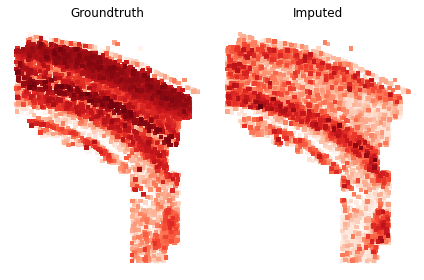

In [35]:
plot_gene_spatial(trainer, data_spatial, 9)

In [39]:
discriminator_classification = trainer.get_discriminator_confusion()


In [40]:
discriminator_classification

array([[0.5133084 , 0.48669136],
       [0.49435076, 0.5056493 ]], dtype=float32)